<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-05-24 11:13:28--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.08s   

2020-05-24 11:13:28 (268 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

/bin/bash: conda: command not found


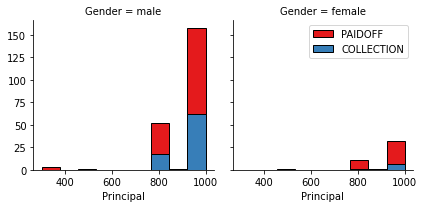

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

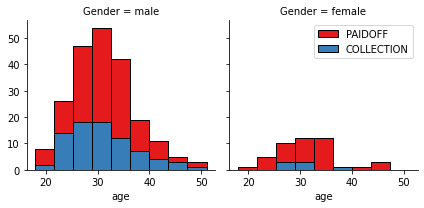

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

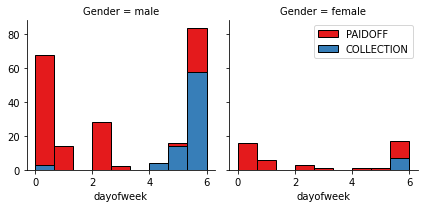

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]


array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# import libraries

In [20]:
!pip3 install shap

     |████████████████████████████████| 276kB 9.0MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394119 sha256=1d3c410f5eb6599b12abc47e7edf847d594333a440a01903e7103c61950637a1
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [0]:
# import data split tool
from sklearn.model_selection import train_test_split

# import Models
# import svm
from sklearn import svm
#import logistic regression
from sklearn.linear_model import LogisticRegression
#import decision tree classifier
from sklearn.tree import DecisionTreeClassifier
# import KNN classifier
from sklearn.neighbors import KNeighborsClassifier
# import gridsearch and K-fold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# import features analysis tools
import matplotlib.image as mpimg
from sklearn.externals.six import StringIO
from sklearn import tree
import pydotplus
import shap

#import metrics evaluation
#from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

# creation of performance reporting function

In [0]:
def results(clf,X_train,y_train,y_test):
    print('+'*20)
    print('best params')
    print(clf.best_params_)
    print('+'*20)
    print('model')
    print(clf.best_estimator_)
    yhat = clf.predict(X_test)
    print('+'*20)
    print("Train set Accuracy: ", accuracy_score(y_train, clf.predict(X_train)))
    print("Test set Accuracy: ", accuracy_score(y_test, yhat))
    print('+'*20)
    print('Jaccard score: '+str(jaccard_similarity_score(y_test, yhat)))
    print('+'*20)
    print('f1_score: '+str(f1_score(y_test, yhat, average='weighted')))
    print('+'*20)
    print('confusion matrix')
    plot_confusion_matrix(clf,X_test, y_test);
    plt.show();
    print('+'*20)
    print('classification report')
    print (classification_report(yhat,y_test))
    print('+'*20)

# split the data 

## with stratification

In [23]:
#split data without imbalance correction
print('+'*20)
print('Stratify to "y" ensure that there is a balance of labels in train and test')
print('+'*20)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=4,stratify=y)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)
print('+'*20)

++++++++++++++++++++
Stratify to "y" ensure that there is a balance of labels in train and test
++++++++++++++++++++
Train set: (259, 8) (259,)
Test set: (87, 8) (87,)
++++++++++++++++++++


## with SMOTE to oversample

In [24]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)
print('+'*20)
print ('Train set:', X_train_smote.shape,  y_train_smote.shape)
print ('Test set:', X_test.shape,  y_test.shape)
print('+'*20)

++++++++++++++++++++
Train set: (390, 8) (390,)
Test set: (87, 8) (87,)
++++++++++++++++++++


# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

## without imbalance correction

https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a

++++++++++++++++++++
best params
{'leaf_size': 55, 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
++++++++++++++++++++
model
KNeighborsClassifier(algorithm='auto', leaf_size=55, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
++++++++++++++++++++
Train set Accuracy:  0.8262548262548263
Test set Accuracy:  0.7241379310344828
++++++++++++++++++++
Jaccard score: 0.7241379310344828
++++++++++++++++++++
f1_score: 0.7196596506941335
++++++++++++++++++++
confusion matrix


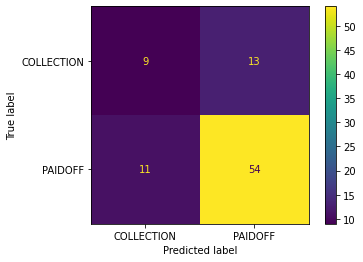

++++++++++++++++++++
classification report
              precision    recall  f1-score   support

  COLLECTION       0.41      0.45      0.43        20
     PAIDOFF       0.83      0.81      0.82        67

    accuracy                           0.72        87
   macro avg       0.62      0.63      0.62        87
weighted avg       0.73      0.72      0.73        87

++++++++++++++++++++


In [25]:
# define the model
model = KNeighborsClassifier()
# define the grid search parameters
n_neighbors = range(1, 21, 2)
leaf_size = range(5, 60, 5)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
grid = dict(n_neighbors=n_neighbors
            ,weights=weights
            ,metric=metric
            ,leaf_size=leaf_size)
# set K fold parameters
cv = RepeatedStratifiedKFold(n_splits=5
                             , random_state=1)
# create and fit classifier
clf = GridSearchCV(estimator=model
                   ,param_grid=grid
                   ,cv=cv
                   , scoring='f1_micro').fit(X_train,y_train)
# print results
results(clf,X_train,y_train,y_test)
#save model
clf_knn = clf.best_estimator_

## with SMOTE

++++++++++++++++++++
best params
{'leaf_size': 5, 'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
++++++++++++++++++++
model
KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='distance')
++++++++++++++++++++
Train set Accuracy:  0.9435897435897436
Test set Accuracy:  0.6666666666666666
++++++++++++++++++++
Jaccard score: 0.6666666666666666
++++++++++++++++++++
f1_score: 0.684593837535014
++++++++++++++++++++
confusion matrix


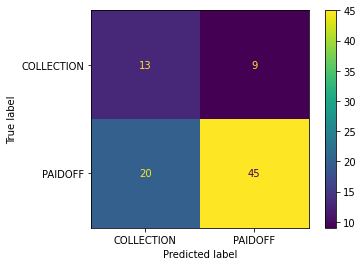

++++++++++++++++++++
classification report
              precision    recall  f1-score   support

  COLLECTION       0.59      0.39      0.47        33
     PAIDOFF       0.69      0.83      0.76        54

    accuracy                           0.67        87
   macro avg       0.64      0.61      0.61        87
weighted avg       0.65      0.67      0.65        87

++++++++++++++++++++


In [26]:
# define the model
model = KNeighborsClassifier()
# define the grid search parameters
n_neighbors = range(1, 21, 2)
leaf_size = range(5, 60, 5)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
grid = dict(n_neighbors=n_neighbors
            ,weights=weights
            ,metric=metric
            ,leaf_size=leaf_size)
# set K fold parameters
cv = RepeatedStratifiedKFold(n_splits=5
                             , random_state=1)
# create and fit classifier
clf = GridSearchCV(estimator=model
                   ,param_grid=grid
                   ,cv=cv
                   , scoring='f1_micro').fit(X_train_smote, y_train_smote)
# print results
results(clf,X_train_smote,y_train_smote,y_test)
#save model
clf_knn_smote = clf.best_estimator_

# Decision Tree

## without imbalance correction

++++++++++++++++++++
best params
{'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 36}
++++++++++++++++++++
model
DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=9, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=36, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')
++++++++++++++++++++
Train set Accuracy:  0.6988416988416989
Test set Accuracy:  0.6551724137931034
++++++++++++++++++++
Jaccard score: 0.6551724137931034
++++++++++++++++++++
f1_score: 0.6761083743842364
++++++++++++++++++++
confusion matrix


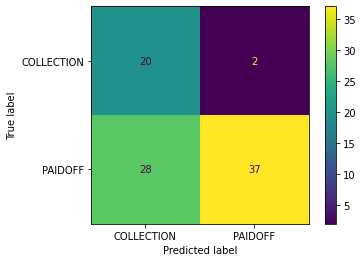

++++++++++++++++++++
classification report
              precision    recall  f1-score   support

  COLLECTION       0.91      0.42      0.57        48
     PAIDOFF       0.57      0.95      0.71        39

    accuracy                           0.66        87
   macro avg       0.74      0.68      0.64        87
weighted avg       0.76      0.66      0.63        87

++++++++++++++++++++


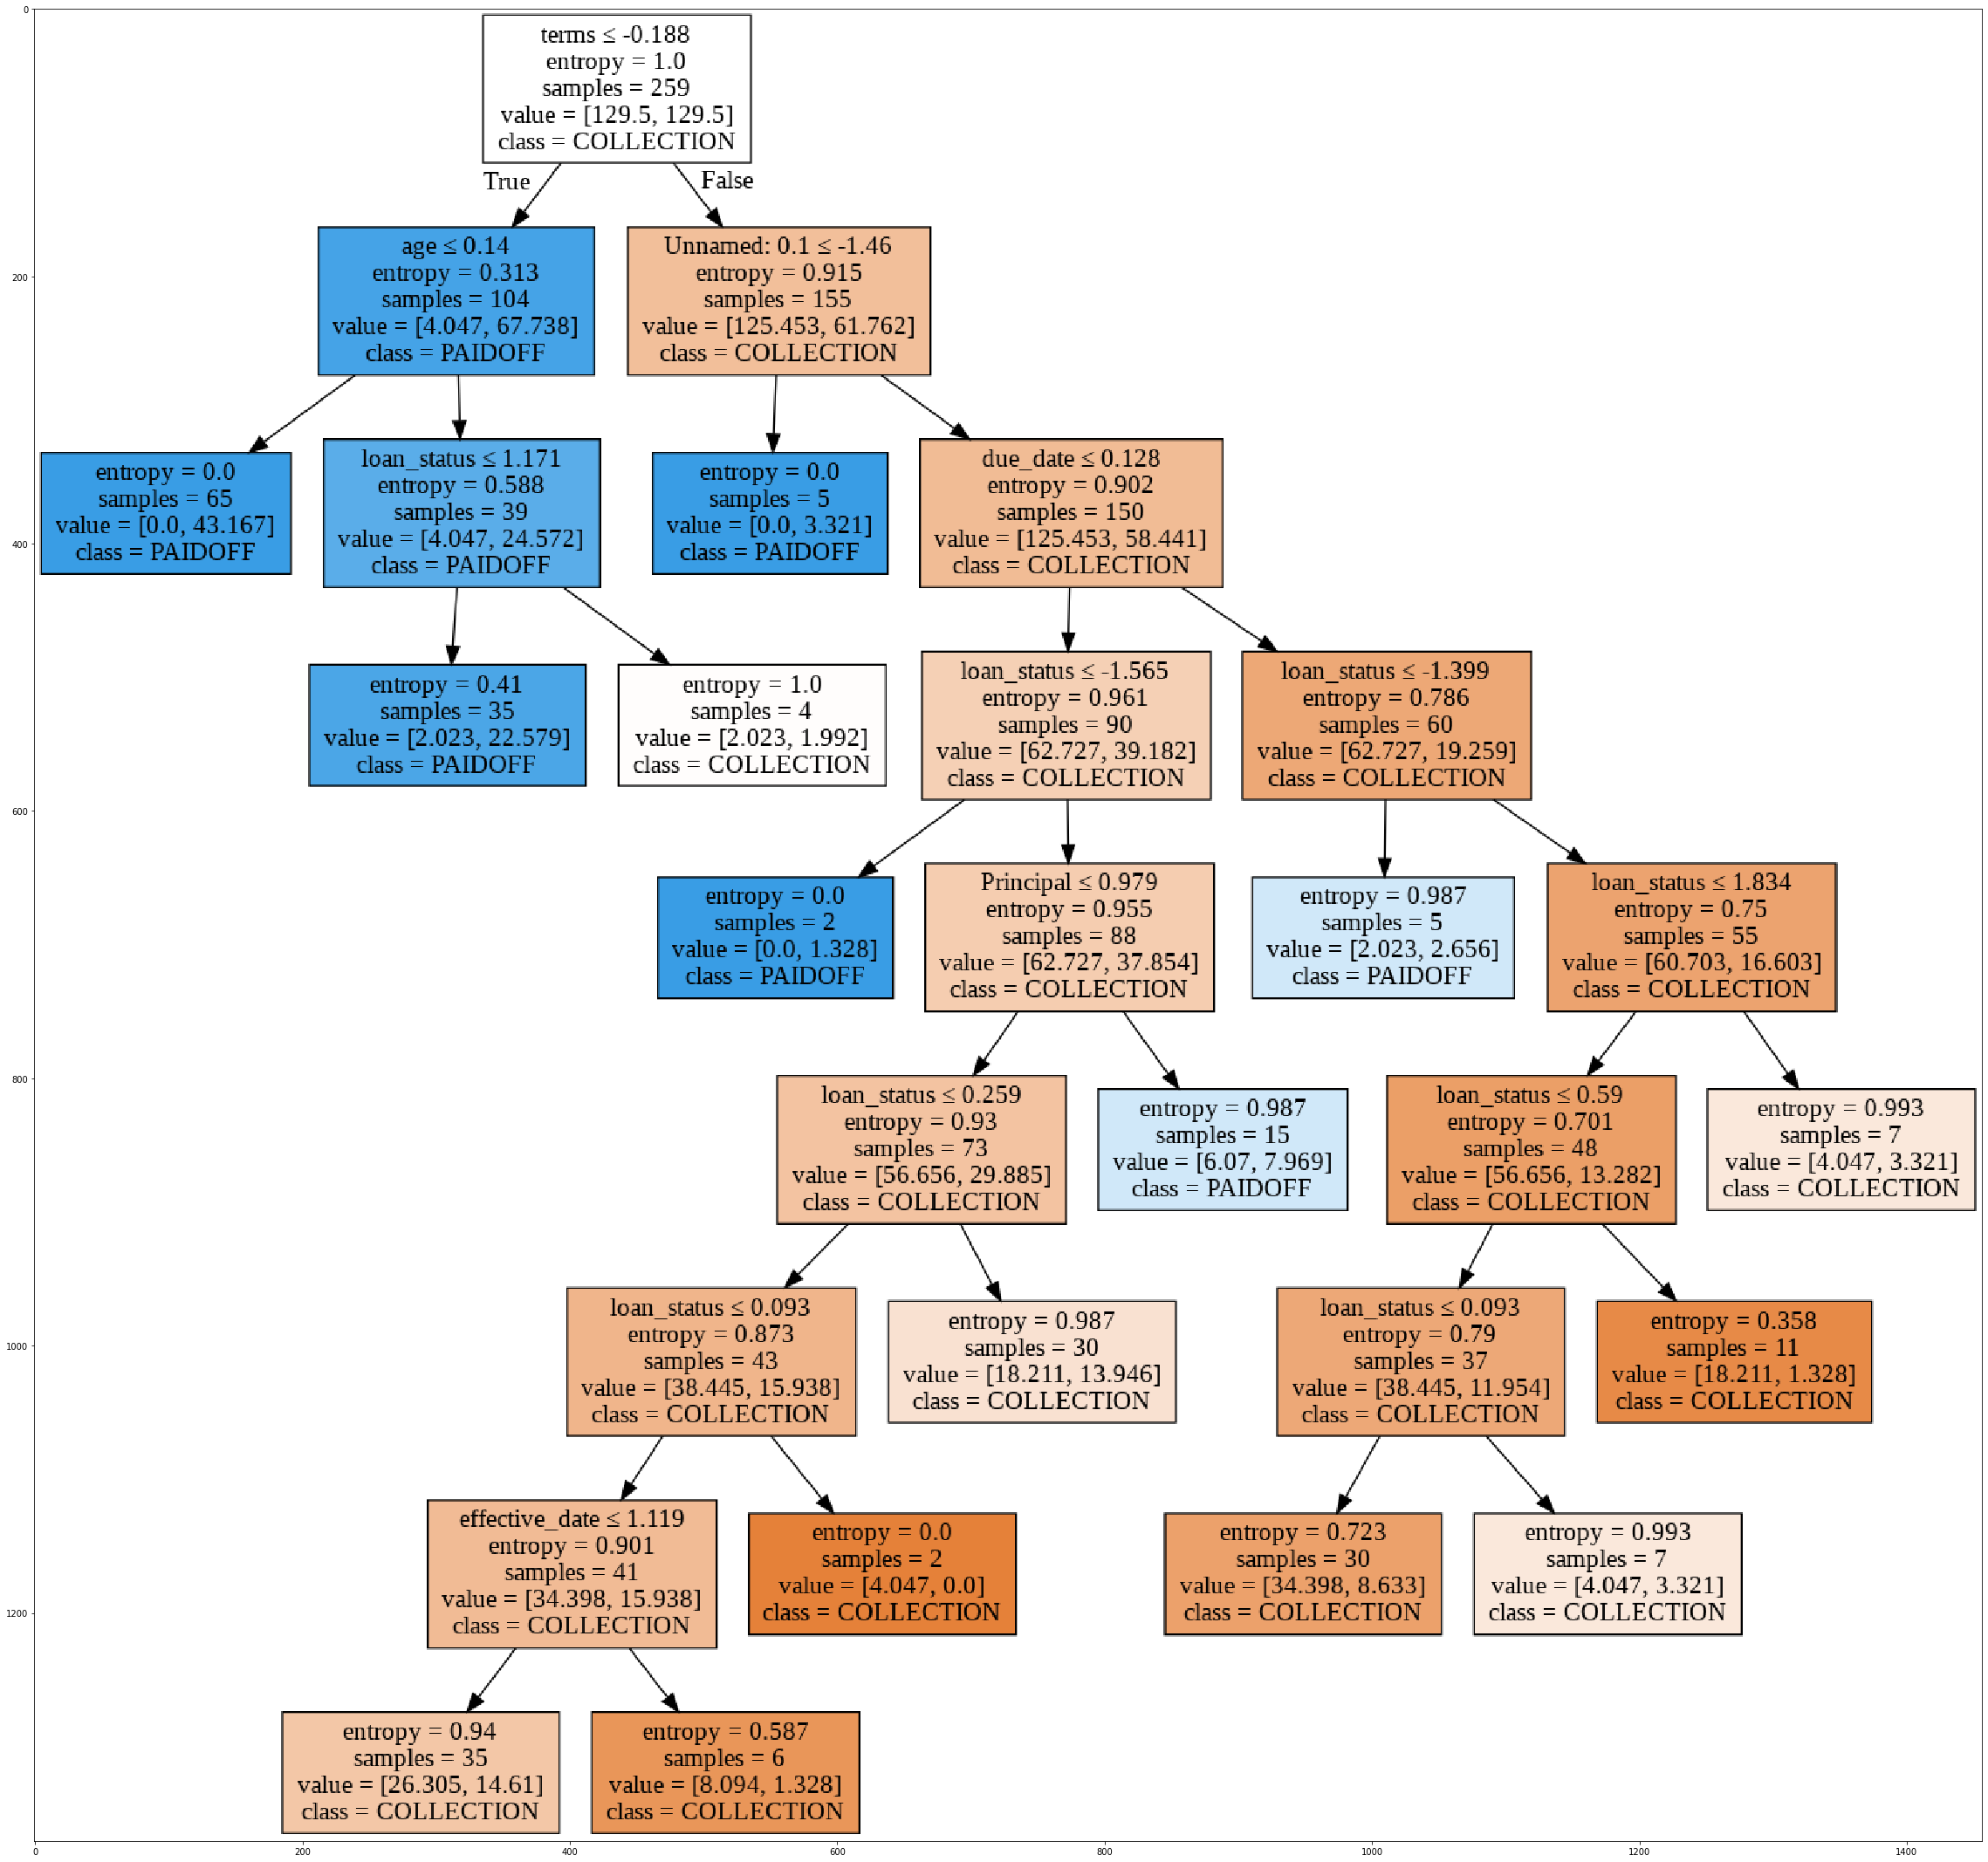

In [27]:
# define the model
model = DecisionTreeClassifier(class_weight='balanced')
# define the grid search parameters
min_samples_split = range(1,100,5)
max_depth = range(1,20,1)
criterion = ['gini', 'entropy']
grid = dict(min_samples_split=min_samples_split,max_depth=max_depth
            ,criterion=criterion)
# set K fold
cv = RepeatedStratifiedKFold(n_splits=5, random_state=1)
# create and fit classifier
clf = GridSearchCV(estimator=model, param_grid=grid, cv=cv,scoring='f1_micro').fit(X_train,y_train)
# print results
results(clf,X_train,y_train,y_test)
#save model
clf_dt = clf.best_estimator_
# print decision tree
dt_model = clf.best_estimator_
dot_data = StringIO()
filename = "drugtree.png"
featureNames = df.columns[0:8]
targetNames = df['loan_status'].unique().tolist()
out=tree.export_graphviz(dt_model,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(40, 80));
plt.imshow(img,interpolation='nearest');

## with SMOTE

++++++++++++++++++++
best params
{'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 36}
++++++++++++++++++++
model
DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=9, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=36, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')
++++++++++++++++++++
Train set Accuracy:  0.7794871794871795
Test set Accuracy:  0.6551724137931034
++++++++++++++++++++
Jaccard score: 0.6551724137931034
++++++++++++++++++++
f1_score: 0.6761083743842364
++++++++++++++++++++
confusion matrix


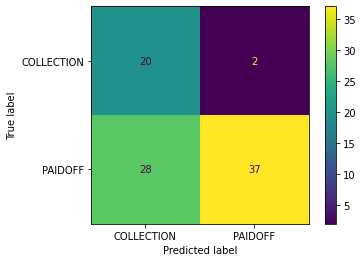

++++++++++++++++++++
classification report
              precision    recall  f1-score   support

  COLLECTION       0.91      0.42      0.57        48
     PAIDOFF       0.57      0.95      0.71        39

    accuracy                           0.66        87
   macro avg       0.74      0.68      0.64        87
weighted avg       0.76      0.66      0.63        87

++++++++++++++++++++


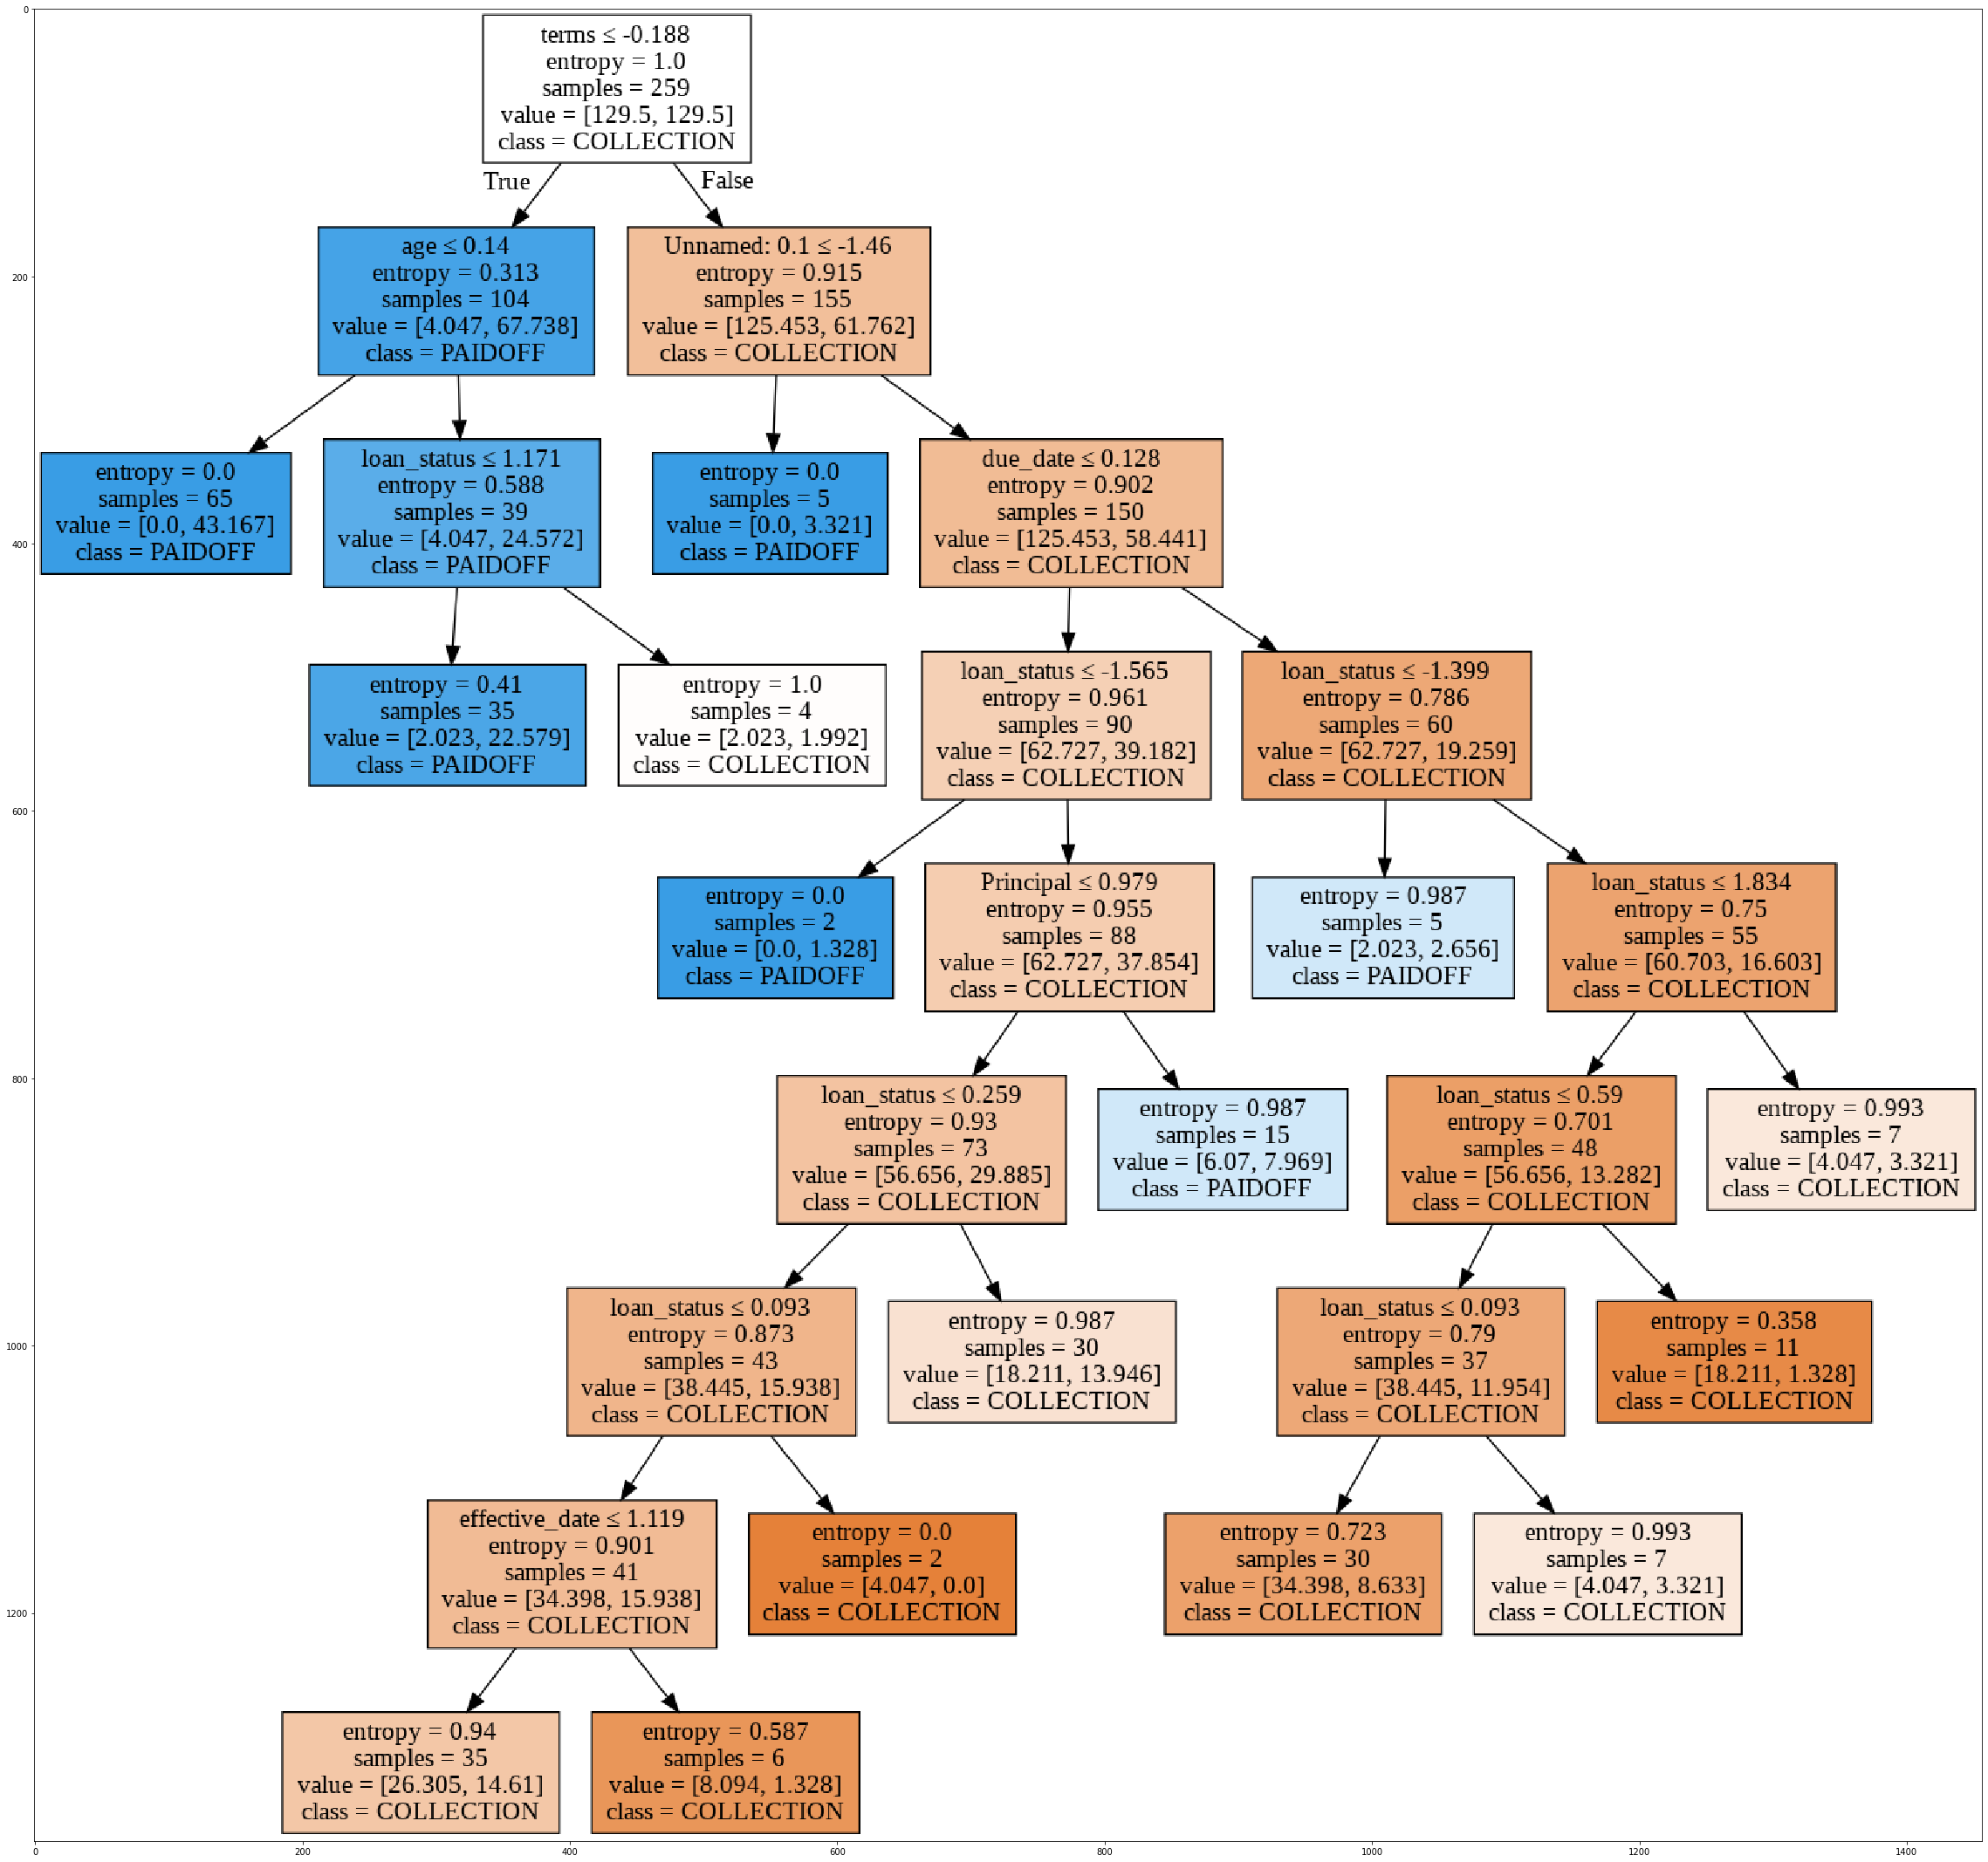

In [28]:
# define the model
model = DecisionTreeClassifier(class_weight='balanced')
# define the grid search parameters
min_samples_split = range(1,100,5)
max_depth = range(1,20,1)
criterion = ['gini', 'entropy']
grid = dict(min_samples_split=min_samples_split,max_depth=max_depth
            ,criterion=criterion)
# set K fold
cv = RepeatedStratifiedKFold(n_splits=5, random_state=1)
# create and fit classifier
clf = GridSearchCV(estimator=model, param_grid=grid, cv=cv,scoring='f1_micro').fit(X_train,y_train)
# print results
results(clf,X_train_smote,y_train_smote,y_test)
clf_dt_smote = clf.best_estimator_
# print decision tree
dt_model = clf.best_estimator_
dot_data = StringIO()
filename = "drugtree.png"
featureNames = df.columns[0:8]
targetNames = df['loan_status'].unique().tolist()
out=tree.export_graphviz(dt_model,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train_smote), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(40, 80));
plt.imshow(img,interpolation='nearest');

# Support Vector Machine

## without imbalance correction

++++++++++++++++++++
best params
{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
++++++++++++++++++++
model
SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
++++++++++++++++++++
Train set Accuracy:  0.7722007722007722
Test set Accuracy:  0.6896551724137931
++++++++++++++++++++
Jaccard score: 0.6896551724137931
++++++++++++++++++++
f1_score: 0.6919005613472333
++++++++++++++++++++
confusion matrix


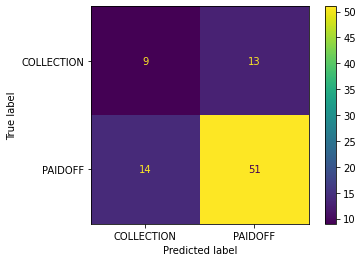

++++++++++++++++++++
classification report
              precision    recall  f1-score   support

  COLLECTION       0.41      0.39      0.40        23
     PAIDOFF       0.78      0.80      0.79        64

    accuracy                           0.69        87
   macro avg       0.60      0.59      0.60        87
weighted avg       0.69      0.69      0.69        87

++++++++++++++++++++


In [29]:
# define the model
model = svm.SVC(class_weight='balanced')
# define the grid search parameters
C = [0.001, 0.01, 0.1, 1, 10, 100]
gamma = [0.0001, 0.001, 0.01, 0.1,1,2]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
grid = dict(C=C
            ,gamma=gamma
            ,kernel=kernel)
# set K fold
cv = RepeatedStratifiedKFold(n_splits=5
                             , random_state=1)
#Create the GridSearchCV object
clf = GridSearchCV(estimator=model
                   ,param_grid=grid
                   , cv=cv
                   , scoring='f1_micro'
                   , refit='AUC').fit(X_train,y_train)
# print results
results(clf,X_train,y_train,y_test)
#save results
clf_svm = clf.best_estimator_

## with SMOTE

++++++++++++++++++++
best params
{'C': 100, 'gamma': 2, 'kernel': 'rbf'}
++++++++++++++++++++
model
SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
++++++++++++++++++++
Train set Accuracy:  0.8974358974358975
Test set Accuracy:  0.6781609195402298
++++++++++++++++++++
Jaccard score: 0.6781609195402298
++++++++++++++++++++
f1_score: 0.6945508727117923
++++++++++++++++++++
confusion matrix


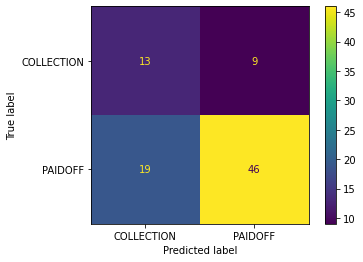

++++++++++++++++++++
classification report
              precision    recall  f1-score   support

  COLLECTION       0.59      0.41      0.48        32
     PAIDOFF       0.71      0.84      0.77        55

    accuracy                           0.68        87
   macro avg       0.65      0.62      0.62        87
weighted avg       0.66      0.68      0.66        87

++++++++++++++++++++


In [30]:
# define the model
model = svm.SVC(class_weight='balanced')
# define the grid search parameters
C = [0.001, 0.01, 0.1, 1, 10, 100]
gamma = [0.0001, 0.001, 0.01, 0.1,1,2]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
grid = dict(C=C
            ,gamma=gamma
            ,kernel=kernel)
# set K fold
cv = RepeatedStratifiedKFold(n_splits=5
                             , random_state=1)
#Create the GridSearchCV object
clf = GridSearchCV(estimator=model
                   ,param_grid=grid
                   , cv=cv
                   , scoring='f1_micro'
                   , refit='AUC').fit(X_train_smote,y_train_smote)
# print results
results(clf,X_train_smote,y_train_smote,y_test)
#save results
clf_svm_smote = clf.best_estimator_

# Logistic Regression

## without imbalance correction

++++++++++++++++++++
best params
{'C': 0.001, 'solver': 'sag'}
++++++++++++++++++++
model
LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)
++++++++++++++++++++
Train set Accuracy:  0.6640926640926641
Test set Accuracy:  0.6781609195402298
++++++++++++++++++++
Jaccard score: 0.6781609195402298
++++++++++++++++++++
f1_score: 0.6977011494252874
++++++++++++++++++++
confusion matrix


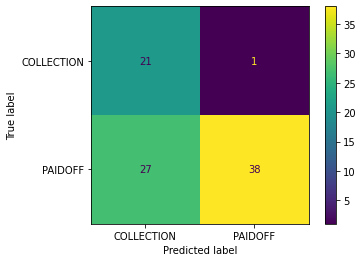

++++++++++++++++++++
classification report
              precision    recall  f1-score   support

  COLLECTION       0.95      0.44      0.60        48
     PAIDOFF       0.58      0.97      0.73        39

    accuracy                           0.68        87
   macro avg       0.77      0.71      0.67        87
weighted avg       0.79      0.68      0.66        87

++++++++++++++++++++


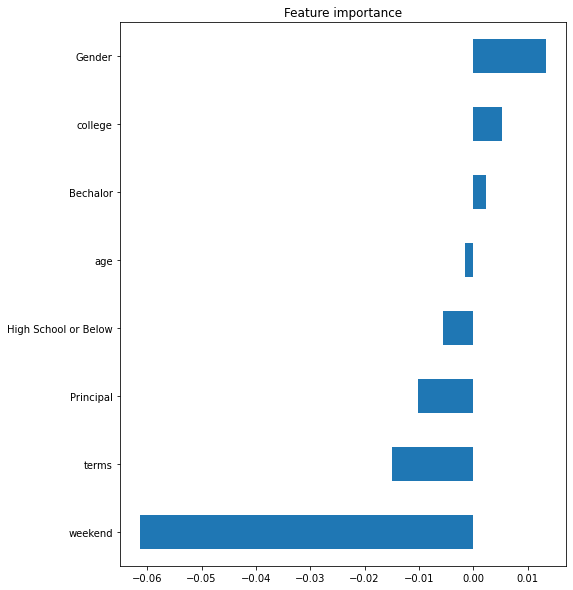

In [31]:
# define the model
model = LogisticRegression(class_weight='balanced')
# define the grid search parameters
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
C =  [0.001, 0.01, 0.1, 1, 10, 100]
grid = dict(solver=solver
            ,C=C)
# set K fold
cv = RepeatedStratifiedKFold(n_splits=5
                             , random_state=1)
#Create the GridSearchCV object
clf = GridSearchCV(estimator=model
                   ,param_grid=grid
                   ,cv=cv
                   ,scoring='f1_micro'
                   ,refit='AUC').fit(X_train,y_train)
# print results
results(clf,X_train,y_train,y_test)
#save results
clf_lr = clf.best_estimator_
# feature importance
coef = pd.Series(clf.best_estimator_.coef_[0], Feature.columns)
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0);
imp_coef.plot(kind = "barh");
plt.title("Feature importance");

## with SMOTE

++++++++++++++++++++
best params
{'C': 0.01, 'solver': 'liblinear'}
++++++++++++++++++++
model
LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
++++++++++++++++++++
Train set Accuracy:  0.764102564102564
Test set Accuracy:  0.6551724137931034
++++++++++++++++++++
Jaccard score: 0.6551724137931034
++++++++++++++++++++
f1_score: 0.6748929456840208
++++++++++++++++++++
confusion matrix


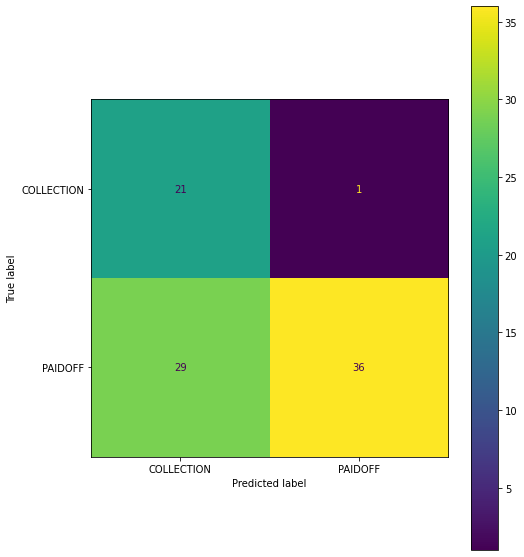

++++++++++++++++++++
classification report
              precision    recall  f1-score   support

  COLLECTION       0.95      0.42      0.58        50
     PAIDOFF       0.55      0.97      0.71        37

    accuracy                           0.66        87
   macro avg       0.75      0.70      0.64        87
weighted avg       0.78      0.66      0.64        87

++++++++++++++++++++


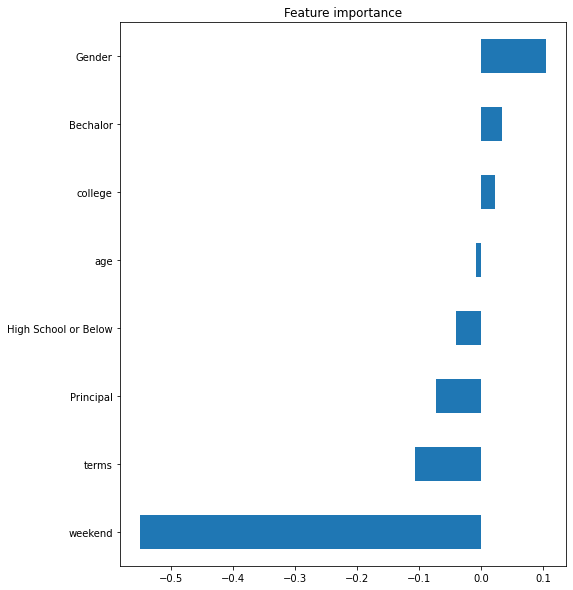

In [32]:
# define the model
model = LogisticRegression(class_weight='balanced')
# define the grid search parameters
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
C =  [0.001, 0.01, 0.1, 1, 10, 100]
grid = dict(solver=solver
            ,C=C)
# set K fold
cv = RepeatedStratifiedKFold(n_splits=10
                             , random_state=1)
#Create the GridSearchCV object
clf = GridSearchCV(estimator=model
                   ,param_grid=grid
                   ,cv=cv
                   ,scoring='f1_micro'
                   ,refit='AUC').fit(X_train_smote,y_train_smote)
# print results
results(clf,X_train_smote,y_train_smote,y_test)
# save model
clf_lr_smote = clf.best_estimator_
# feature importance
coef = pd.Series(clf.best_estimator_.coef_[0], Feature.columns)
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0);
imp_coef.plot(kind = "barh");
plt.title("Feature importance");

# Model Evaluation using Test set

In [0]:
#from sklearn.metrics import jaccard_similarity_score
#from sklearn.metrics import f1_score
#from sklearn.metrics import log_loss

First, download and load the test set:

In [34]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-05-24 12:39:14--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-05-24 12:39:15 (524 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Prepare data

In [35]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature = test_df[['Principal','terms','age','Gender','weekend','dayofweek']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

X = Feature

y = test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values

testy=y.astype(float)
testX= preprocessing.StandardScaler().fit_transform(X)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [36]:
test_df = pd.read_csv('loan_test.csv')
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_X = Feature

test_y = test_df['loan_status'].values
test_y[0:5]
test_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_X[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

## KNN

In [37]:
yhat =clf_knn.predict(test_X)
print('Not using SMOTE')
print('+'*20)
print('Jaccard score: '+str(jaccard_similarity_score(test_y, yhat)))
print('+'*20)
print('f1_score: '+str(f1_score(test_y, yhat, average='weighted')))
print('+'*20)
print('+'*20)
print('Using SMOTE')
yhat =clf_knn_smote.predict(test_X)
print('+'*20)
print('Jaccard score: '+str(jaccard_similarity_score(test_y, yhat)))
print('+'*20)
print('f1_score: '+str(f1_score(test_y, yhat, average='weighted')))
print('+'*20)

Not using SMOTE
++++++++++++++++++++
Jaccard score: 0.6851851851851852
++++++++++++++++++++
f1_score: 0.6886205279919816
++++++++++++++++++++
++++++++++++++++++++
Using SMOTE
++++++++++++++++++++
Jaccard score: 0.6666666666666666
++++++++++++++++++++
f1_score: 0.68671679197995
++++++++++++++++++++


## Decision Tree

In [38]:
yhat =clf_dt.predict(test_X)
print('Not using SMOTE')
print('+'*20)
print('Jaccard score: '+str(jaccard_similarity_score(test_y, yhat)))
print('+'*20)
print('f1_score: '+str(f1_score(test_y, yhat, average='weighted')))
print('+'*20)
print('+'*20)
print('Using SMOTE')
yhat =clf_dt_smote.predict(test_X)
print('+'*20)
print('Jaccard score: '+str(jaccard_similarity_score(test_y, yhat)))
print('+'*20)
print('f1_score: '+str(f1_score(test_y, yhat, average='weighted')))
print('+'*20)

Not using SMOTE
++++++++++++++++++++
Jaccard score: 0.6851851851851852
++++++++++++++++++++
f1_score: 0.7045531151828931
++++++++++++++++++++
++++++++++++++++++++
Using SMOTE
++++++++++++++++++++
Jaccard score: 0.6851851851851852
++++++++++++++++++++
f1_score: 0.7045531151828931
++++++++++++++++++++


## SVM

In [39]:
yhat =clf_svm.predict(test_X)
print('Not using SMOTE')
print('+'*20)
print('Jaccard score: '+str(jaccard_similarity_score(test_y, yhat)))
print('+'*20)
print('f1_score: '+str(f1_score(test_y, yhat, average='weighted')))
print('+'*20)
print('+'*20)
print('Using SMOTE')
yhat =clf_svm_smote.predict(test_X)
print('+'*20)
print('Jaccard score: '+str(jaccard_similarity_score(test_y, yhat)))
print('+'*20)
print('f1_score: '+str(f1_score(test_y, yhat, average='weighted')))
print('+'*20)

Not using SMOTE
++++++++++++++++++++
Jaccard score: 0.7777777777777778
++++++++++++++++++++
f1_score: 0.7645502645502646
++++++++++++++++++++
++++++++++++++++++++
Using SMOTE
++++++++++++++++++++
Jaccard score: 0.6851851851851852
++++++++++++++++++++
f1_score: 0.6886205279919816
++++++++++++++++++++


## Logistics regression

In [48]:
yhat =clf_lr.predict(test_X)
print('Not using SMOTE')
print('+'*20)
print('Jaccard score: '+str(jaccard_similarity_score(test_y, yhat)))
print('+'*20)
print('f1_score: '+str(f1_score(test_y, yhat, average='weighted')))
print('+'*20)
yproba=clf_lr.predict_proba(test_X)
print('log_loss: ' +str(log_loss(test_y, yproba)))
print('+'*20)
print('+'*20)
print('Using SMOTE')
yhat =clf_lr_smote.predict(test_X)
print('+'*20)
print('Jaccard score: '+str(jaccard_similarity_score(test_y, yhat)))
print('+'*20)
print('f1_score: '+str(f1_score(test_y, yhat, average='weighted')))
print('+'*20)
yproba=clf_lr_smote.predict_proba(test_X)
print('log_loss: ' +str(log_loss(test_y, yproba)))
print('+'*20)

Not using SMOTE
++++++++++++++++++++
Jaccard score: 0.6481481481481481
++++++++++++++++++++
f1_score: 0.6689193665937851
++++++++++++++++++++
log_loss: 0.6776506044269094
++++++++++++++++++++
++++++++++++++++++++
Using SMOTE
++++++++++++++++++++
Jaccard score: 0.6666666666666666
++++++++++++++++++++
f1_score: 0.6856060606060607
++++++++++++++++++++
log_loss: 0.6056600294914589
++++++++++++++++++++


In [44]:
yproba=clf_lr.predict_proba(test_X)
log_loss(test_y, yproba)

0.6776506044269094

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.685       | 0.688       | NA      |
| Decision Tree      | 0.685       | 0.704        | NA      |
| SVM                | 0.777       | 0.764        | NA      |
| LogisticRegression | .666      | .685        | .677       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>

# to have multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# load and see structure of the data
df = pd.read_csv('loan_train.csv')
# convert to datetime object
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
print('\033[1m'+'show top two rows of df'+'\033[0m')
df.head(2)
print('\033[1m'+'show column names of df'+'\033[0m')
df.columns
print('\033[1m'+'show shape of df'+'\033[0m')
df.shape
# how many people have paid off and how many debt have been collected
print('\033[1m'+'Paid off VS Collected'+'\033[0m')
print('Loans paid off = '+str(df['loan_status'].value_counts()[0]))
print('Loans collected = '+str(df['loan_status'].value_counts()[1]))
df.hist(figsize=(10,10));